In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import uncertainties.unumpy as unp
import matplotlib as mpl
import uncertainties as u
import os
from scipy.special import erfc
from lmfit import Model, fit_report
from datetime import datetime
from uncertainties import ufloat
from matplotlib import font_manager
from scipy.stats import chi2
from scipy.optimize import curve_fit
from IPython.display import Markdown
from io import StringIO

# Math Functions

In [2]:
def rect(x, b0, b1, mean):
    '''
    Descripción
    -----------
    Cálculo de una función lineal a partir de unos parámetros dados.
    
    Parámetros
    ----------
    x (float or np.array): Variable dependiente
    b0 (float): Corte con el eje y
    b1 (float): Pendiente
    mean (float): Centroide

    Retorna
    -------
    Arreglo (o valor individual) de la función evaluada en x
    '''
    return b0 + b1*(mean-x) #Background

##############################################################################

#Función Error Complemento
def rerfc(x, b0, b1, mean, stdev):
    '''
    Descripción
    -----------
    Función que calcula el fondo de un ajuste gaussiano describiendo la
    función error complemento adaptada a los parámetros de la gaussiana.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.
    
    Retorna
    -------
    Los valores de la función error complemento adaptada a la gaussiana del ajuste.
    '''
    return b0 + (b1/2)*erfc((x-mean)/(np.sqrt(2)*stdev)) #Background

##############################################################################

#Función Gaussiana con Fondo Lineal
def gaussian_rect(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, mean) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, mean, stdev) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Error by Poisson's Distribution
def Poisson_Incertidumbre(y_values):
    '''
    Descripción
    -----------
    Se calcula la incertidumbre de los valores de las cuentas/canal de un espectro a
    partir del error de acuerdo a la distribución de Poisson.

    Parámetros
    ----------
    y_values (np.array): Valores de cuentas/canal en un espectro.

    Retorna:
    --------
    sigma_y (np.array): Valores de la incertidumbre asignada a los valores de las 
                        cuentas/canal de un espectro
    '''
    sigma_y = np.sqrt(np.abs(y_values))
    for i in range(len(y_values)):
        if y_values[i] == 0:
            sigma_y[i] = 1
    return sigma_y
#Función de 2 Gaussianas con Fondo Lineal
def gaussian_rect_2(x, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, (mean1+mean2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc_2(x, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, (mean1+mean2)/2, (stdev1+stdev2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)


# Formato grafico

In [3]:
#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    # Configurar la notación científica
    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))

    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels, edgecolor='1', framealpha=0.5, prop=font)


# Fit functions

## Curvefit

## lmfit

In [4]:
def lmfit_custom_fit(x, y_with_unc, modelo, xmin, xmax):
    """
    Ajusta un modelo a datos con incertidumbre usando lmfit. Calcula τ y κ con propagación
    de incertidumbre y los incluye como parámetros fijos en el fit_report.

    Parameters:
    - x (np.array): canales
    - y_with_unc (np.array of ufloat): cuentas con incertidumbre
    - modelo (function): modelo a ajustar (sin τ ni κ como parámetros)
    - xmin, xmax (int): índice de rango de ajuste

    Returns:
    - result (lmfit.model.ModelResult): resultado del ajuste
    """

    # Separar nominales y desviaciones
    y_nom = unp.nominal_values(y_with_unc)
    y_err = unp.std_devs(y_with_unc)

    # Subconjunto del rango de ajuste
    x_fit = x[xmin:xmax]
    y_fit = y_nom[xmin:xmax]
    y_fit_err = y_err[xmin:xmax]

    # Determinar si es modelo de un pico o doble pico
    is_double_peak = (modelo.__name__ == 'gaussian_rect_2' or modelo.__name__ == 'gaussian_erfc_2')

    # Crear modelo
    Rmodel = Model(modelo)
    params = Rmodel.make_params()
    
    # Estimaciones iniciales base
    idx_max = np.argmax(y_fit)
    peak_max = y_fit[idx_max]
    peak_pos = x_fit[idx_max]
    stdev_guess = (x_fit[-1] - x_fit[0]) / 6

    # Añadir parámetros básicos comunes
    params.add('b0', value=1, vary=True)
    params.add('b1', value=1, vary=True)

    if is_double_peak:
        # Buscar posibles dos picos
        # (Este es un enfoque simple, se puede mejorar)
        half_width = len(x_fit) // 3
        
        # Buscar el primer pico en la primera mitad del rango
        y_left = y_fit[:len(y_fit)//2]
        idx_max1 = np.argmax(y_left)
        peak_pos1 = x_fit[idx_max1]
        peak_max1 = y_fit[idx_max1]
        
        # Buscar el segundo pico en la segunda mitad del rango
        y_right = y_fit[len(y_fit)//2:]
        idx_max2 = np.argmax(y_right) + len(y_fit)//2
        peak_pos2 = x_fit[idx_max2]
        peak_max2 = y_fit[idx_max2]
        
        # Si los picos están muy cerca, intentar otra estrategia
        if abs(peak_pos2 - peak_pos1) < stdev_guess:
            # Usar el pico principal y estimar un segundo pico cercano
            peak_pos1 = peak_pos - stdev_guess
            peak_pos2 = peak_pos + stdev_guess
            peak_max1 = peak_max * 0.7
            peak_max2 = peak_max * 0.7
        
        # Añadir parámetros para modelo de doble pico
        params.add('M1', value=peak_max1, vary=True, min=0)
        params.add('M2', value=peak_max2, vary=True, min=0)
        params.add('mean1', value=peak_pos1, vary=True, min=0)
        params.add('mean2', value=peak_pos2, vary=True, min=0)
        params.add('stdev1', value=stdev_guess, vary=True, min=0)
        params.add('stdev2', value=stdev_guess, vary=True, min=0)
    else:
        # Añadir parámetros para modelo de un solo pico
        params.add('M', value=peak_max, vary=True, min=0)
        params.add('mean', value=peak_pos, vary=True, min=0)
        params.add('stdev', value=stdev_guess, vary=True, min=0)

    # Ajuste
    result = Rmodel.fit(y_fit, x=x_fit, params=params, weights=1/y_fit_err, nan_policy='omit')
    parametros = result.params

    return result, parametros

def plot_and_markdown_fit_report(result, x, y, x_ajuste, y_ajuste, recta_ajuste, 
                                titulo="Ajuste", unidades="canal", ylim=None,
                                save_path=None, show_plot=True):
    """
    Genera gráfica del ajuste + fit_report en formato Markdown extendido.
    Compatible con modelos de un pico y doble pico.

    Parameters:
    - result: objeto de resultado de lmfit
    - x, y: datos experimentales (sin incertidumbre)
    - x_ajuste: eje x del modelo ajustado
    - y_ajuste: modelo completo (recta + gauss)
    - recta_ajuste: modelo de fondo lineal
    - titulo: título del gráfico y nombre del archivo
    - unidades: 'canal' o 'keV'
    - ylim: límites opcionales para eje y
    - save_path: ruta donde guardar la imagen
    - show_plot: si se debe mostrar el gráfico en pantalla

    Returns:
    - Markdown fit report como objeto renderizable en Jupyter
    """

    # Determinar si es modelo de un pico o doble pico
    is_double_peak = 'mean1' in result.params and 'mean2' in result.params
    
    # ----- GRAFICAR -----
    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    
    # Etiqueta de la curva de ajuste según el tipo de modelo
    if is_double_peak:
        curve_label = r'Modelo de doble pico gaussiano'
    else:
        curve_label = r'Modelo de pico simple gaussiano'
        
    # Etiqueta de fondo según tipo de modelo
    if 'gaussian_erfc' in titulo:
        bg_label = r'Fondo con función error'
    else:
        bg_label = r'Fondo lineal'
    
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2, label=curve_label)
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=bg_label)

    plt.grid()
    plt.title(titulo)
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    plt.legend(loc='best')

    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$' + ' (keV)')

    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    
    if save_path is not None:
        filename = f"Practica2_{titulo.replace(' ', '_')}.png"
        full_path = os.path.join(save_path, filename)
        plt.savefig(full_path, dpi=300, bbox_inches='tight')

    if show_plot:
        plt.show()
    
    # -------- CALCULAR TAU Y KAPPA --------
    # Solo para modelos de un pico
    if not is_double_peak:
        # Recuperar parámetros ajustados con incertidumbre
        mean = ufloat(result.params['mean'].value, result.params['mean'].stderr)
        stdev = ufloat(result.params['stdev'].value, result.params['stdev'].stderr)

        # Diferencias para momentos centrales
        dif = x_ajuste - mean
        # Usar wrap para incertidumbre
        wrapped_mean = u.wrap(np.mean)

        momento_3 = wrapped_mean((dif)**3)
        momento_4 = wrapped_mean((dif)**4)

        tau = momento_3 / (stdev**3)
        kappa = momento_4 / (stdev**4)
    
    # ----- CALCULAR Q -----
    Chi2 = result.chisqr
    df = result.ndata - result.nvarys
    Q = chi2.sf(Chi2, df).astype(np.float64)
    
    # ----- FIT REPORT -----
    report = fit_report(result, show_correl=False, min_correl=0.1).split('\n')
    
    extended_report = []
    for line in report:
        extended_report.append(line)
        if 'R-squared' in line:
            extended_report.append(f'     Q  = {Q:.8f}')
            extended_report.append(f'     df = {df}')
        
        # Añadir tau y kappa solo para modelos de un pico
        if not is_double_peak and 'stdev' in line:
            extended_report.append(f'    Tau:    {tau:.8f}')
            extended_report.append(f'    Kappa:  {kappa:.8f}')
    
    markdown_text = '```text\n' + '\n'.join(extended_report) + '\n```'
    return Markdown(markdown_text)

## ODR

# Main function

In [38]:

def load_spectrum_with_uncertainty(file_path):
    """
    Carga un archivo .mca ignorando encabezados y basura final.
    Lee solo datos entre <<DATA>> y <<END>> o hasta donde sean válidos.

    Returns:
    - channels: np.array de canales generados automáticamente
    - spectrum_with_unc: np.array de ufloat con cuentas e incertidumbre de Poisson
    """
    import numpy as np
    from uncertainties import unumpy as unp

    counts = []
    data_section = False

    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            line = line.strip()

            if '<<DATA>>' in line:
                data_section = True
                continue
            elif '<<END>>' in line:
                break

            if data_section:
                try:
                    value = float(line)
                    counts.append(value)
                except ValueError:
                    continue  # ignorar líneas basura

    counts = np.array(counts)
    channels = np.arange(len(counts))
    #channels = data[:, 0].flatten()
    uncertainties = Poisson_Incertidumbre(counts)
    spectrum_with_unc = unp.uarray(counts, uncertainties)

    return channels, spectrum_with_unc



def peak_fit(raw_data_path, background_path, 
             peak_configs, width=3.5,
             save_path="Imagenes", unidades="canal", ylim=None):
    """
    Carga datos crudos y de fondo, aplica propagación de incertidumbre y 
    muestra un gráfico del espectro corregido. Luego analiza los picos
    en los rangos especificados con el método indicado para cada pico.

    Parameters:
    - raw_data_path (str): Ruta al archivo de datos crudos
    - background_path (str): Ruta al archivo de fondo
    - peak_configs (list): Lista de diccionarios con la configuración de cada pico.
                          Cada diccionario debe tener las claves:
                          - "min_range": Canal mínimo
                          - "max_range": Canal máximo
                          - "method": Método a usar (1, 2, 3 o 4)
                          Ejemplo: [{"min_range": 100, "max_range": 150, "method": 1}, ...]
    - width (float): Factor para calcular el ancho del segundo ajuste (default: 3.0)
    - save_path (str): Ruta opcional para guardar el gráfico
    - unidades (str): Unidades para el eje x (default: "canal")
    - ylim (tuple): Límites para el eje y (opcional)

    Returns:
    - all_results (list): Lista con los resultados de todos los segundos ajustes
    """

    print(f"\n➡️ Cargando datos con incertidumbre de Poisson...")
    channels_raw, raw_with_unc = load_spectrum_with_uncertainty(raw_data_path)
    channels_back, background_with_unc = load_spectrum_with_uncertainty(background_path)

    if len(raw_with_unc) != len(background_with_unc):
        raise ValueError("⚠️ Raw data and background must be the same length.")

    corrected_data = raw_with_unc - background_with_unc
    corrected_counts = unp.nominal_values(corrected_data)

    # Número de picos basado en la longitud de peak_configs
    num_peaks = len(peak_configs)

    # Lista para almacenar los resultados
    all_results = []

    print(f"\n🧾 Procesando {num_peaks} picos...")

    for i in range(num_peaks):
        print(f"\n--- Pico #{i+1} ---")
    
        # Obtener configuración del pico actual
        config = peak_configs[i]
        min_range = config["min_range"]
        max_range = config["max_range"]
        method = config["method"]
    
        print(f"Usando rango: Canal mínimo = {min_range}, Canal máximo = {max_range}")
        print(f"Método seleccionado: {method}")
    
        try:
            # Seleccionar modelo según método especificado para este pico
            if method == 1:
                modelo = gaussian_rect
                model_name = "gaussian_rect"
            elif method == 2:
                modelo = gaussian_erfc
                model_name = "gaussian_erfc"
            elif method == 3:
                modelo = gaussian_rect_2
                model_name = "gaussian_rect_2"
            elif method == 4:
                modelo = gaussian_erfc_2
                model_name = "gaussian_erfc_2"
            else:
                raise ValueError(f"Método no válido para el pico #{i+1}. Usa 1, 2, 3 o 4.")
        
            # Convertir a índices de canal
            idx_min = int(np.searchsorted(channels_raw, min_range))
            idx_max = int(np.searchsorted(channels_raw, max_range))
        
            # Datos para ajuste
            x = channels_raw
            y_with_unc = corrected_data
        
            # Primer ajuste
            results, params = lmfit_custom_fit(x, y_with_unc, modelo, idx_min, idx_max)
            
            # Preparar datos para gráfica del primer ajuste
            x_data = x[idx_min:idx_max]
            y_nom = unp.nominal_values(y_with_unc[idx_min:idx_max])
            #params = results.params
            x_ajuste = np.linspace(min_range, max_range, 500)
            
            # Calcular valores del modelo para la curva de ajuste
            if method == 1:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta = params['b0'].value + params['b1'].value * (params['mean'] - x_ajuste)
            elif method == 2:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta = params['b0'].value + (params['b1'].value)*erfc((x_ajuste - params['mean'])/(np.sqrt(2)*params['stdev']))
            elif method == 3:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta = params['b0'].value + params['b1'].value * (0.5*(params['mean1'] + params['mean2']) - x_ajuste)
            elif method == 4:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                # Promedio de dos funciones erfc para doble pico
                recta = params['b0'].value + (params['b1'].value) * 0.5 * (
                    erfc((x_ajuste - params['mean1'])/(np.sqrt(2)*params['stdev1'])) + 
                    erfc((x_ajuste - params['mean2'])/(np.sqrt(2)*params['stdev2']))
                )
            
            # Título automático para el primer ajuste
            titulo = f"Pico_{i+1}_{model_name}_primer_ajuste"
            
            # Graficar y mostrar Markdown report para el primer ajuste
            md = plot_and_markdown_fit_report(
                result=results,
                x=x_data,
                y=y_nom,
                x_ajuste=x_ajuste,
                y_ajuste=y_ajuste,
                recta_ajuste=recta,
                titulo=titulo,
                unidades=unidades,
                ylim=ylim,
                save_path=save_path,
                show_plot=True
            )
            display(md)
            
            # Realizar segundo ajuste con nuevos rangos calculados
            # Para métodos de doble pico, usamos el promedio de medias y desviaciones
            if method in [1, 2]:
                parameters = [params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']]
                mean = parameters[3]
                stdev = parameters[4]             
                x0_new = int(mean - width * stdev)
                x1_new = int(mean + width * stdev)
            else:  # Para métodos 3 y 4 (doble pico)
                mean1 = params['mean1'].value
                mean2 = params['mean2'].value
                stdev1 = params['stdev1'].value
                stdev2 = params['stdev2'].value
                # Usar el promedio o el valor más grande para determinar el rango
                mean = (mean1 + mean2) / 2
                stdev = max(stdev1, stdev2)          
                x0_new = int(mean1 - width * stdev1)
                x1_new = int(mean2 + width * stdev2)

            
            print(f"Realizando segundo ajuste con rango: Canal mínimo = {x0_new}, Canal máximo = {x1_new}")
            
            # Convertir a índices de canal para el segundo ajuste
            idx_min_new = int(np.searchsorted(channels_raw, x0_new))
            idx_max_new = int(np.searchsorted(channels_raw, x1_new))
            
            # Segundo ajuste
            results_new , params_new = lmfit_custom_fit(x, y_with_unc, modelo, idx_min_new, idx_max_new)
            
            # Preparar datos para gráfica del segundo ajuste
            x_data_new = x[idx_min_new:idx_max_new]
            y_nom_new = unp.nominal_values(y_with_unc[idx_min_new:idx_max_new])
            #params_new = results_new.params
            x_ajuste_new = np.linspace(x0_new, x1_new, 500)
            
            # Calcular valores del modelo y línea base para el segundo ajuste
            if method == 1:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta_new = params_new['b0'].value + params_new['b1'].value * (params_new['mean'] - x_ajuste_new)
            elif method == 2:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta_new = params_new['b0'].value + (params_new['b1'].value/2)*erfc((x_ajuste_new - params_new['mean'])/(np.sqrt(2)*params_new['stdev']))
            elif method == 3:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta_new = params_new['b0'].value + params_new['b1'].value * (0.5*(params_new['mean1'] + params_new['mean2']) - x_ajuste_new)
            elif method == 4:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta_new = params_new['b0'].value + (params_new['b1'].value) * 0.5 * (
                    erfc((x_ajuste_new - params_new['mean1'])/(np.sqrt(2)*params_new['stdev1'])) + 
                    erfc((x_ajuste_new - params_new['mean2'])/(np.sqrt(2)*params_new['stdev2']))
                )
            
            # Título automático para el segundo ajuste
            titulo_new = f"Pico_{i+1}_{model_name}_segundo_ajuste"
            
            # Graficar y mostrar Markdown report para el segundo ajuste
            md_new = plot_and_markdown_fit_report(
                result=results_new,
                x=x_data_new,
                y=y_nom_new,
                x_ajuste=x_ajuste_new,
                y_ajuste=y_ajuste_new,
                recta_ajuste=recta_new,
                titulo=titulo_new,
                unidades=unidades,
                ylim=ylim,
                save_path=save_path,
                show_plot=True
            )
            display(md_new)
            
            # Guardar resultados del segundo ajuste
            all_results.append(results_new)
            
        except Exception as e:
            print(f"❌ Error en el pico #{i+1}: {str(e)}")
            continue
    
    # Retornar todos los resultados del segundo ajuste
    return all_results

# Main block


➡️ Cargando datos con incertidumbre de Poisson...

🧾 Procesando 2 picos...

--- Pico #1 ---
Usando rango: Canal mínimo = 10, Canal máximo = 70
Método seleccionado: 2


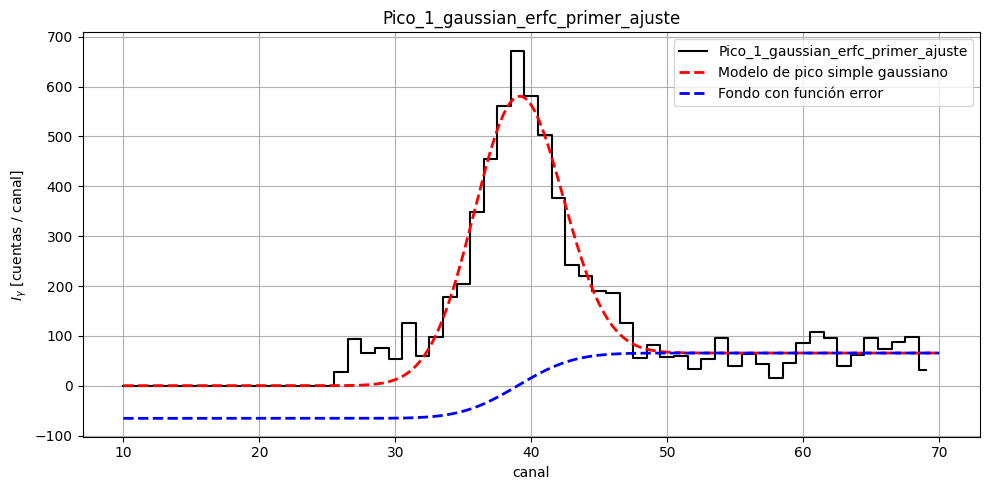

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 60
    # variables        = 5
    chi-square         = 89.9617602
    reduced chi-square = 1.63566837
    Akaike info crit   = 34.3024079
    Bayesian info crit = 44.7741307
    R-squared          = 0.95202846
     Q  = 0.00204403
     df = 55
[[Variables]]
    b0:     65.5773386 +/- 8.40389169 (12.82%) (init = 1)
    b1:    -65.5040015 +/- 8.41439502 (12.85%) (init = 1)
    M:      547.163929 +/- 23.1014774 (4.22%) (init = 672)
    mean:   39.0010451 +/- 0.14806364 (0.38%) (init = 39)
    stdev:  3.25637668 +/- 0.14060660 (4.32%) (init = 9.833333)
    Tau:    26.16983798+/-5.15788192
    Kappa:  1468.32116968+/-253.64634481
```

Realizando segundo ajuste con rango: Canal mínimo = 26, Canal máximo = 51


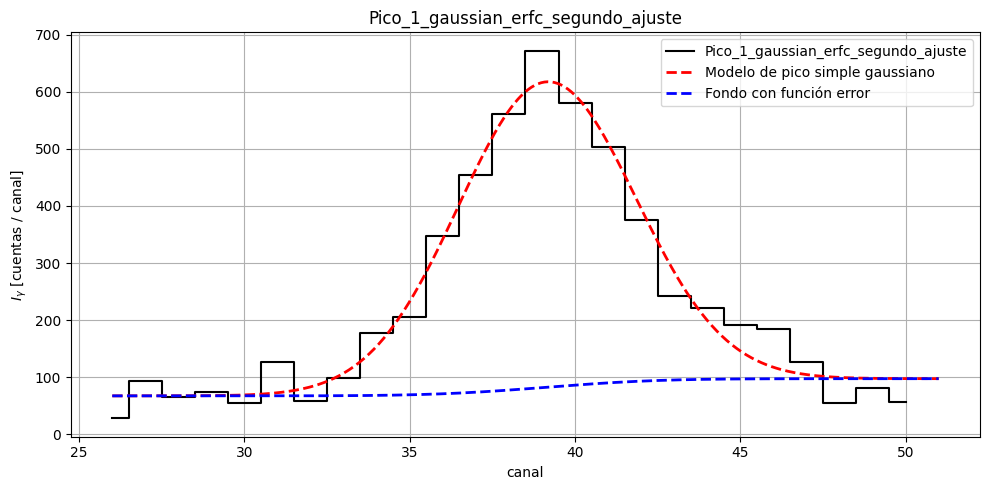

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 25
    # variables        = 5
    chi-square         = 29.5954872
    reduced chi-square = 1.47977436
    Akaike info crit   = 14.2186516
    Bayesian info crit = 20.3130308
    R-squared          = 0.97256118
     Q  = 0.07667874
     df = 20
[[Variables]]
    b0:     97.4641185 +/- 16.0231879 (16.44%) (init = 1)
    b1:    -30.0998574 +/- 18.8352646 (62.58%) (init = 1)
    M:      535.072856 +/- 25.1951419 (4.71%) (init = 672)
    mean:   39.1297112 +/- 0.15233165 (0.39%) (init = 39)
    stdev:  2.68388335 +/- 0.14631701 (5.45%) (init = 4)
    Tau:    -5.12276068+/-1.50106142
    Kappa:  97.26181120+/-21.24151418
```


--- Pico #2 ---
Usando rango: Canal mínimo = 550, Canal máximo = 800
Método seleccionado: 1


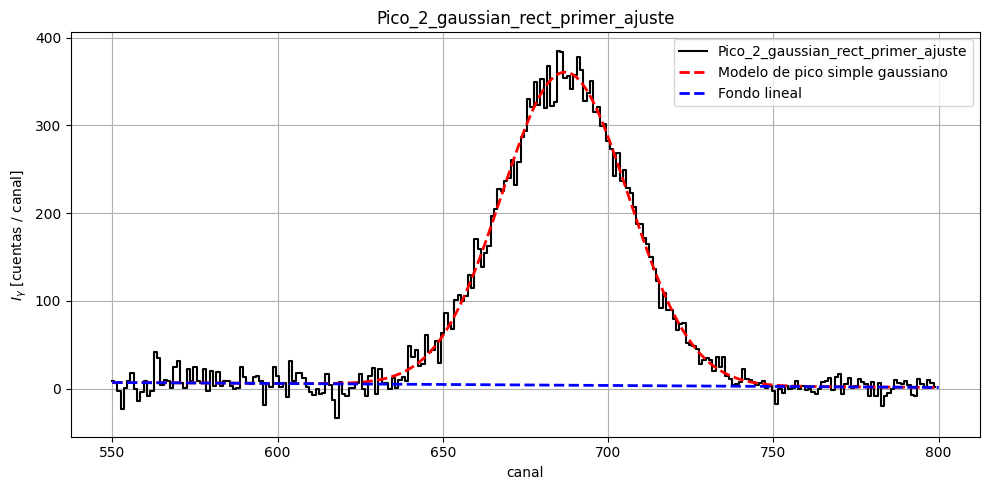

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 250
    # variables        = 5
    chi-square         = 219.162863
    reduced chi-square = 0.89454230
    Akaike info crit   = -22.9114497
    Bayesian info crit = -5.30414509
    R-squared          = 0.98869814
     Q  = 0.88111162
     df = 245
[[Variables]]
    b0:     3.77433717 +/- 0.78598475 (20.82%) (init = 1)
    b1:     0.02262800 +/- 0.00860477 (38.03%) (init = 1)
    M:      356.743648 +/- 3.82514643 (1.07%) (init = 385)
    mean:   686.960540 +/- 0.19908879 (0.03%) (init = 685)
    stdev:  19.1767626 +/- 0.19157289 (1.00%) (init = 41.5)
    Tau:    -26.84877594+/-0.92437423
    Kappa:  397.28915198+/-15.91453228
```

Realizando segundo ajuste con rango: Canal mínimo = 616, Canal máximo = 757


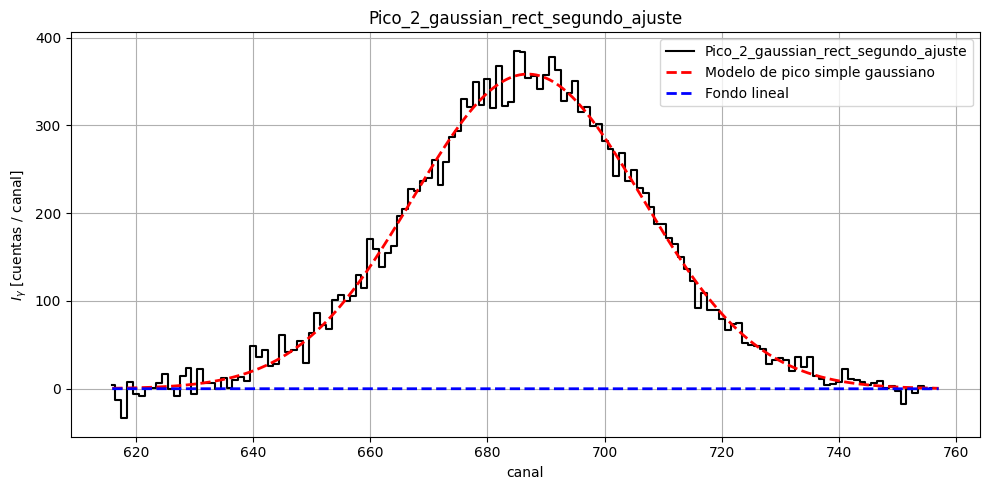

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 141
    # variables        = 5
    chi-square         = 108.476124
    reduced chi-square = 0.79761856
    Akaike info crit   = -26.9744014
    Bayesian info crit = -12.2306020
    R-squared          = 0.99000305
     Q  = 0.96043905
     df = 136
[[Variables]]
    b0:    -0.26627279 +/- 1.60490867 (602.73%) (init = 1)
    b1:     5.4593e-04 +/- 0.02292205 (4198.70%) (init = 1)
    M:      358.632583 +/- 3.63970145 (1.01%) (init = 385)
    mean:   686.878557 +/- 0.20632396 (0.03%) (init = 685)
    stdev:  19.5544102 +/- 0.22435539 (1.15%) (init = 23.33333)
    Tau:    -0.25265357+/-0.13798521
    Kappa:  34.07252582+/-1.56374601
```

In [40]:
# Definir los rangos de los picos
configuracion_picos = [
    {"min_range": 10, "max_range": 70 , "method": 2},   # Pico 1 con método 1
    {"min_range": 550, "max_range": 800, "method": 1},  # Pico 2 con método 2

]

# Llamar a la función con la configuración especificada
resultados = peak_fit(
    raw_data_path="Informe2/Data/NaI-SiPM-137Cs-ST-0.050us-0.787us-1200s.mca",
    background_path="Informe2/Data/NaI-SiPM-Fondo-ST-0.050us-0.787us-1200s.mca",
    peak_configs=configuracion_picos,
    width=3.7,
    save_path="Imagenes",
    unidades="canal"
)

In [ ]:

channels, spectrum_with_unc1 = load_spectrum_with_uncertainty("Informe2/Data/NaI_137Cs_600s.dat")
channels, spectrum_with_unc2 = load_spectrum_with_uncertainty("Informe2/Data/NaI_Fondo_600s.dat")
spectrum_with_unc = spectrum_with_unc1 - spectrum_with_unc2
nominal_vals = unp.nominal_values(spectrum_with_unc)
std_devs = unp.std_devs(spectrum_with_unc)

for i in range(len(channels)):
    print(f"Canal {int(channels[i])}: {nominal_vals[i]:.2f} ± {std_devs[i]:.2f}")



NameError: name 'nominal_vals' is not defined